In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import sys

from astropy import units as u
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from astropy.coordinates import SkyCoord
from astropy.coordinates import GCRS
from astropy.coordinates import get_moon
from astropy.time import Time
from datetime import datetime


import PIL.Image
from astropy.utils.data import get_pkg_data_filename

#to load wcs:
#import cairo

In [5]:
#data
all_files = !ls ../Data_CometHolmes
jpeg_files = all_files[0::2] #to get only the jpeg files
#getting the image numbers

image_number = []
for i in jpeg_files:
    image_number.append(i[7:11])

In [6]:
#getting the exif
import PIL.Image
img = []
exif_data = []
n=0
for i in range(len(jpeg_files)):
    img.append(PIL.Image.open('../Data_CometHolmes/' + jpeg_files[i]))
    exif_data.append(img[i].getexif())

pic_date_time = []
# associate picture number with time 
for i in range(1299):
    pic_date_time.append([image_number[i], exif_data[i].get(306)])

#get only the ones with EXIF values
pdt_exif = [row for row in pic_date_time if row[1] != None ]

#some entries have the form: '2007:10:30 14:29:03\x00', so let's remove the weird ending
for i in range(len(pdt_exif)):
    if len(pdt_exif[i][1]) == 20:
        pdt_exif[i][1] = pdt_exif[i][1][:-1]

#discrepency between paper and code: we have 11 more timestamped images !!!!

In [9]:

#woups! we need JD date!!!
#we need the following format: '2010-01-01T00:00:00'

#getting the format
dates = np.transpose(pdt_exif)[1]
print(datetime.strptime(dates[1], "%Y:%m:%d  %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S"))

m = len(pdt_exif)
pdt_julian = pdt_exif

for i in range(m):
    date_time_string = pdt_exif[i][1]
    #right format
    d = datetime.strptime(date_time_string, "%Y:%m:%d  %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S")
    pdt_julian[i][1] = d
pdt_julian

2007-11-06T19:02:26


[['0001', '2007-11-01T21:44:30'],
 ['0003', '2007-11-06T19:02:26'],
 ['0004', '2007-11-08T00:37:30'],
 ['0010', '2007-11-06T23:49:01'],
 ['0011', '2007-11-06T23:49:01'],
 ['0042', '2007-11-04T17:04:49'],
 ['0064', '2007-11-05T18:16:11'],
 ['0074', '2007-11-06T17:30:57'],
 ['0078', '2007-10-24T23:56:47'],
 ['0106', '2007-10-31T10:32:19'],
 ['0127', '2007-10-28T10:03:53'],
 ['0139', '2007-11-20T13:10:51'],
 ['0215', '2007-12-18T02:45:32'],
 ['0219', '2007-11-02T19:14:37'],
 ['0270', '2007-12-08T17:36:17'],
 ['0274', '2007-11-24T19:57:20'],
 ['0276', '2007-10-28T16:32:09'],
 ['0279', '2007-11-22T17:50:30'],
 ['0280', '2007-11-22T16:04:39'],
 ['0281', '2007-11-24T19:56:54'],
 ['0282', '2007-11-22T10:39:20'],
 ['0283', '2007-11-24T22:15:59'],
 ['0284', '2007-11-07T09:36:44'],
 ['0285', '2007-11-24T19:56:18'],
 ['0286', '2007-11-17T09:55:03'],
 ['0302', '2007-10-30T14:29:03'],
 ['0303', '2007-10-30T14:28:47'],
 ['0307', '2007-11-02T11:43:37'],
 ['0308', '2007-11-02T11:43:51'],
 ['0314', '200

In [10]:
#get julian times
times = np.transpose(pdt_julian)[1]
t = Time(times, format='isot', scale='utc').jd

In [11]:
def date2julian(date_string):
    date = datetime.strptime(date_string, "%Y:%m:%d  %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S")
    julian = Time(date, format='isot', scale='utc').jd
    return julian

t_min = date2julian("2007:07:02  00:00:00") #july 1st 2007
t_max = date2julian("2008:05:01  00:00:00") #may 1st 2008
print(t_min, t_max)


2454283.5 2454587.5


delta time: 304.0 , # bins: 38 38.0


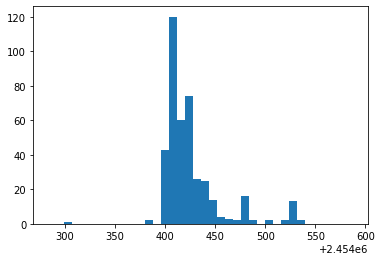

In [12]:
delta_t = t_max-t_min
bins_width = 8.0 #number of days in JD is just the number of days
bins_num = int(delta_t/bins_width) #integer

print('delta time:', delta_t, ', # bins:', bins_num,delta_t/bins_width)

#keep only times between t_min and t_max
#times_filtered = [i for i in t if not  i <= t_min and i <= t_max] 
hist_array, hist_bins, hist_patches = plt.hist(t, bins = bins_num, range = (t_min, t_max));


In [13]:
extra_counts = np.linspace(t_min + 4.0, t_max + 4.0, 39)

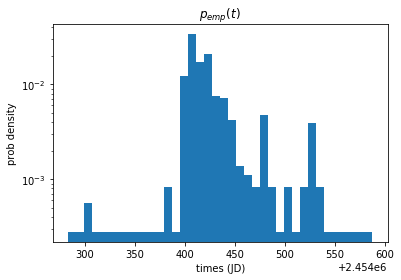

In [14]:
plt.title('$p_{emp}(t)$')
plt.xlabel('times (JD)')
plt.ylabel('prob density')
plt.semilogy()
prob_time, bins_norm, patches_norm = plt.hist(np.concatenate((t, extra_counts)), bins = bins_num, range = (t_min, t_max), density = True)


In [17]:
#likelihood (just a product of the single image likelihoods )
def likelihood(img_liks):
    return np.product(img_liks)

In [18]:
#a marginalization over time, we will be using an evenly spaced grid of times
#we need to compute one single likelihood 
def single_image_likelihood():
    return 0
    

In [19]:
#function that takes the position and velocity vectors at a certain epoch and returns the ICRS coordinates of the
#object over a time grid (these are approximately ICRS, but the orbit is really around the CM of the sun and
#not the solar system barycenter)
#r and v are three element lists that represent vectors and need to have the proper units appended
#2454416 = November 12th 2007

def orbit_sim(r, v,  n_points, t_i, t_f, epoch = 2454416):
    #making a list of times to sample:
    times = np.linspace(t_i, t_f, n_points)
    
    #making the propagation delta
    prop_delta = [(i - epoch)*u.day for i in times]
    
    #defining orbit object
    orbit = Orbit.from_vectors(Sun, r, v)
    
    #initialize array to store the positions
    locations = [0 for i in range(n_points)]
    
    #looping over linspace to evaluate the orbit at all of these points
    for i in range(len(prop_delta)):
        locations[i] = orbit.propagate(prop_delta[i]).rv()[0]
    
    return [locations, times]

In [20]:
#function that takes the cartesian (x,y,z) in ICRS frame and returns the ra and dec as seen from the earth
def ICRS_to_GCRS(positions, times):
    
    coords = [0 for i in range(len(times))]
    
    
    for i in range(len(positions)):
        temp_time = Time(times[i], format='jd')
        X,Y,Z = positions[i].value
        temp_coord = SkyCoord(x = X, y = Y, z = Z, unit='km' ,frame = 'icrs' , representation_type = 'cartesian', obstime=temp_time)
        coords[i] = temp_coord.transform_to('gcrs')
        
    return coords
        

In [21]:
simulated = orbit_sim([10**8,10**8,10**8]*u.km, [0,0,5]*u.km/u.s, 20, 2454283.5, 2454587.5, 2454416)
ICRS_to_GCRS(simulated[0], simulated[1])

[<SkyCoord (GCRS: obstime=2454283.5, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
     (74.15878633, 34.63600923, 2.86838846e+08)>,
 <SkyCoord (GCRS: obstime=2454299.5, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
     (86.24701281, 36.59514986, 2.53934026e+08)>,
 <SkyCoord (GCRS: obstime=2454315.5, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
     (103.5331847, 37.07667233, 2.11842373e+08)>,
 <SkyCoord (GCRS: obstime=2454331.5, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
     (131.65963509, 30.92954325, 1.67572176e+08)>,
 <SkyCoord (GCRS: obstime=2454347.5, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
     (144.35974515, 14.19482312, 1.38396556e+08)>,
 <SkyCoord (GCRS: obstime=2454363.5, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m 

In [22]:
#takes a plt.imread image, WCS object from .wcs file, eta (0,1), and point is a SkyCoord object
#deterimines if point is in the eta subimage of the image as defined in the paper

def subimage_contains(img, wcs_func, eta, point):
    
    #assigning variables to the image dimensions
    a,b = img.shape[:2]
    
    #variable assignments that have to do with determining whether the point is in the eta subimage
    r_eta = np.sqrt(eta)
    am = int(a*(1-r_eta)/2)
    ap = int(a*(1+r_eta)/2)
    bm = int(b*(1-r_eta)/2)
    bp = int(b*(1+r_eta)/2)
    
    #boolean values 
    Abool = point.contained_by(wcs_func, image = np.ones((b,am)))
    Bbool = point.contained_by(wcs_func, image = np.ones((bm,a)))
    Cbool = point.contained_by(wcs_func, image = np.ones((bp,ap)))
    
    #boolshit
    final_bool = (not Abool) and (not Bbool) and (Cbool)
    
    return final_bool

In [23]:
# takes an image (from plt.imread) with its corresponding wcs file, then computes the trajectory of the comet
# as seen from Earth and determines whether the comet can be found in a subimage 
def find_comet(r, v, eta, n_points, img, wcs_func, t_i, t_f):
    
    #get the comet's position over time grid    
    pos, time =  orbit_sim(r, v,  n_points, t_i, t_f)
    
    #transform to RA and DEC
    sky_coords = ICRS_to_GCRS(pos, time)
    
    #determine whether the comet can be found in a subimage for each image
    bool_comet = [False for i in range(len(sky_coords))]
    for i in range(len(sky_coords)):
        bool_comet[i] = subimage_contains(img, wcs_func, eta, sky_coords[i])
        
    return bool_comet


In [24]:
test_image = plt.imread('../Data_CometHolmes/holmes-0001.jpg')
test_wcs = wcs.WCS('../Data_CometHolmes/holmes-0001.wcs')

In [25]:
find_comet([10**8,10**8,10**8]*u.km, [0,0,5]*u.km/u.s, 0.8 , 10, test_image, test_wcs,2454283.5,2454587.5)

[False, False, False, False, False, False, False, False, False, False]

In [26]:
#takes in r,v,eta,n params and the image's wcs to compute p_fg (eq.3) 
def p_fg(r, v, eta, n_points, img, wcs_func, wcs_info, t_i, t_f):
    
    #solid angle
    field_area = float(wcs_info[32][10:])
    solid_angle = field_area*(np.pi/(60*180))**2 #converting degs^2 to solid angle (sr)
    
    #determine whether a sub image contains the comet    
    comet_bool = find_comet(r, v, eta, n_points, img, wcs_func, t_i, t_f)
    comet_int = np.array([int(i) for i in comet_bool])
    
    return comet_int/(solid_angle*eta) 
#eq 4
def p_bg(n_points):
    return np.ones((n_points))/(4*np.pi)

In [27]:
#how to get wcs info
#a = !/Users/anahoban/software/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-0001.wcs


In [28]:
#function that evaluates eq. 2 using p_fg and p_bg
def tdep_sim_likelihood(r, v, eta, n_points, img, wcs_func, wcs_info, p_good, t_i, t_f):
    p_f = p_fg(r, v, eta, n_points, img, wcs_func, wcs_info, t_i, t_f)
    p_b = p_bg(n_points)
    
    return p_good*p_f + (1 - p_good)*p_b

In [29]:
def p_emp(time, bins_norm):
    '''Takes time and returns probability of getting that time based on time hist'''
    if bins_norm[0] > time or time > bins_norm[len(bins_norm)-1]:
            return 'Given date is not between July 1st 2007 and May 1st 2008.'
    else:
            for i in range(len(bins_norm)-1):
                if bins_norm[i] <= time and time <= bins_norm[i+1]:
                    return prob_time[i]  


def t_prior(number, time, p_exif, pdt_exif, pdt_julian, bins_norm):
    '''Takes an image and checks whether or not it has a EXIF and gives prior depending on that time (array)'''
    pdt_transpose = np.transpose(pdt_julian)
    dates_list = pdt_transpose[0].tolist()
    
    #if it has EXIF date:
    if number in np.transpose(pdt_exif):
        #get its EXIF date:
        index = dates_list.index(number)
        
        #date in JD:
        exif_date = Time(pdt_transpose[1][index], format='isot', scale='utc').jd
        
        prob = []
        for t in time:
            prob.append(p_exif * uniform_t(exif_date, t) + (1-p_exif)*p_emp(t,bins_norm))
        return np.array(prob)
        
        
    #if it doesn't have an EXIF date
    else:
        prob = []
        for t in time:
            prob.append(p_emp(t, bins_norm))
        return np.array(prob)
    
def uniform_t(t_exif, time):
    '''uniform distribution of t_i w.r.t t_exif +- 0.5 days. All times and in JD'''
    if t_exif - 0.5 <= time and time <= t_exif + 0.5:
        return 1 
    else:
        return 0
    

In [30]:
def single_im_likelihood(number, p_exif, pdt_exif, pdt_julian, bins_norm, r, v, eta, n_points, img, wcs_func, wcs_info, p_good, t_i , t_f ):
        time = np.linspace(t_i, t_f, n_points)
        integrand = t_prior(number, time, p_exif, pdt_exif, pdt_julian, bins_norm)*tdep_sim_likelihood(r, v, eta, n_points, img, wcs_func, wcs_info, p_good, t_i, t_f)
        
        return np.sum(integrand)*(t_f-t_i)/(n_points-1) #note: we may not need the multiplication by delta t
    

In [43]:
number = '0002'
image = plt.imread('../Data_CometHolmes/holmes-%s.jpg'%(number))
wcs_header = wcs.WCS('../Data_CometHolmes/holmes-%s.wcs'%(number))
a = !/usr/local/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{number}.wcs
single_im_likelihood(number, 0.8, pdt_exif, pdt_julian, bins_norm, [10**8,10**8,10**8]*u.km, [0,0,5]*u.km/u.s, 0.8, 30, image, wcs_header, a, 0.8, 2454283.5, 2454587.5)




0.01723190528922156

In [51]:
#loading in data 
wcs_list = [wcs.WCS('../Data_CometHolmes/holmes-%s.wcs'%(i)) for i in image_number]
img_list = [plt.imread('../Data_CometHolmes/holmes-%s.jpg'%(i)) for i in image_number]
wcs_info = [1 for i in image_number]
for i in range(len(image_number)):
    wcs_info[i] = !/usr/local/astrometry/bin/wcsinfo ../Data_CometHolmes/holmes-{image_number[i]}.wcs


In [62]:
def all_im_likelihoods(number_lis, p_exif, pdt_exif, pdt_julian, bins_norm, r, v, eta, n_points, p_good, wcs_list, img_list, wcs_info, t_i = 2454283.5, t_f = 2454587.5):
    product_list = [1 for i in number_lis]
    
    for i in range(len(number_lis)):
        image = img_list[i]
        wcs_header = wcs_list[i]
        wcs_inf = wcs_info[i]
        product_list[i] = single_im_likelihood(number_lis[i], p_exif, pdt_exif, pdt_julian, bins_norm, r, v, eta, n_points, image, wcs_header, wcs_inf, p_good, t_i, t_f)
    
    return np.prod(product_list)
        
    

In [ ]:
all_im_likelihoods(image_number, 0.8, pdt_exif, pdt_julian, bins_norm, [10**8, 10**8, 10**8]*u.km, [5,0,0]*u.km/u.s, 0.8, 2, 0.7, wcs_list, img_list, wcs_info)

